# Импорты библиотек

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
from datetime import datetime

# Чтение данных

In [2]:
df_path = "marketplace.csv"

df = pd.read_csv(df_path)
display(df.head())
df.info()

,user_id,platform_num,first_login,reg_dt,browser,first_buy,target,total_buy,total_return
0,user_000000,12,2025-03-22,2024-08-17,browser_00,2025-03-22,0.0,85.329559,0.0
1,user_000001,1,2025-05-05,2025-05-15,browser_01,2025-05-20,0.0,21.819124,0.0
2,user_000002,5,2025-01-19,2025-01-23,browser_02,2025-02-20,0.3,194.612980,485.0
3,user_000003,3,2025-03-15,2023-09-05,browser_02,NaN,0.0,138.780814,0.0
4,user_000004,1,2025-05-05,2025-05-14,browser_00,2025-05-11,0.0,16.334507,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25335 entries, 0 to 25334
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       25335 non-null  object 
 1   platform_num  25335 non-null  int64  
 2   first_login   25335 non-null  object 
 3   reg_dt        25331 non-null  object 
 4   browser       25335 non-null  object 
 5   first_buy     24361 non-null  object 
 6   target        25335 non-null  float64
 7   total_buy     25335 non-null  float64
 8   total_return  25335 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 1.7+ MB


# Чистка данных

Очищенные данные кладем в переменную df_cleaned. 

После очистки запишем данные в новый файл marketplace_cleaned.csv для быстрого доступа к ним.
1. Преобразовать типов
1. Дубли юзеров сливаем в одну запись суммируя покупки и возвраты, таргет - среднее
1. Формат данных - юзеров делаем индексами
1. Заполнить пустые даты. Отбросить выбросы. Взять среднее кол-во дней между датой регистрации и датой покупки. Заполнить пустые даты регистрации вычитая среднее кол-во дней между покупкой и регистрацией.


## Преобразование типов

In [3]:
df_cleaned = df.copy()

# df_cleaned = df_cleaned.astype({'reg_dt': int, 'first_buy': int, 'first_login': dt})

df_cleaned["reg_dt"] = pd.to_datetime(df_cleaned["reg_dt"], errors="coerce")
df_cleaned["first_buy"] = pd.to_datetime(df_cleaned["first_buy"], errors="coerce")
df_cleaned["first_login"] = pd.to_datetime(df_cleaned["first_login"], errors="coerce")

df_cleaned["user_id"] = df_cleaned["user_id"].apply(lambda x: int(x.strip("user_")))
df_cleaned["browser"] = df_cleaned["browser"].apply(lambda x: int(x.strip("browser_")))

## Заполнение нулей

In [4]:
df_cleaned["first_buy"].fillna(df_cleaned[['first_login', 'reg_dt']].max(axis=1), inplace=True)

## Склеивание дублей и индексация по user_id

In [5]:
df_cleaned = df_cleaned.groupby(by="user_id").agg(
    {
        "platform_num": "min",
        "first_login": "min",
        "reg_dt": "min",
        "browser": "min",
        "first_buy": "min",
        "target": "mean",
        "total_buy": "sum",
        "total_return": "sum",
    }
)
df_cleaned.head()

,platform_num,first_login,reg_dt,browser,first_buy,target,total_buy,total_return
user_id,,,,,,,,
0,12,2025-03-22,2024-08-17,0,2025-03-22,0.0,85.329559,0.0
1,1,2025-05-05,2025-05-15,1,2025-05-20,0.0,21.819124,0.0
2,5,2025-01-19,2025-01-23,2,2025-02-20,0.3,194.612980,485.0
3,3,2025-03-15,2023-09-05,2,2025-03-15,0.0,138.780814,0.0
4,1,2025-05-05,2025-05-14,0,2025-05-11,0.0,16.334507,0.0


### Вспомогательные методы

In [6]:
def shapiro_check(dataset, col, alpha=0.05):
    """
    Шапиро. Тест, является ли распределение СВ нормальным
    """
    stat, pvalue = st.shapiro(dataset[col].sample(n=3000))
    if pvalue > alpha:
        print(f'Данные {col} скорее всего распределены нормально')
    else:
        print(f'Данные {col} скорее всего распределены не нормально')

def kstest_check(dataset, col, alpha=0.05):
    """
    Колмогоров-Смирнов. Тест, является ли распределение СВ нормальным
    """
    arr = dataset[col]
    mu = arr.mean()
    sigma = arr.std(ddof=1)
    stat, pvalue = st.kstest(arr, 'norm', args=(mu, sigma))
    if pvalue > alpha:
        print(f'Данные {col} скорее всего распределены нормально')
    else:
        print(f'Данные {col} скорее всего распределены не нормально')

def iqr_filter(dataset, col):
    """
    Фильтр по межквартильному р
    """
    medi = dataset[col].median()  
    Q1, Q3 = dataset[col].quantile([0.25, 0.75]) 
    IQR = Q3 - Q1
    
    bottom, top = medi - 1.5 * IQR, medi + 1.5 * IQR

    return dataset[(dataset[col] >= bottom) & (dataset[col] <= top)]

## Устраняем асинхронность в датах - дата первой покупки не должна быть меньше даты логина или регистрации

In [7]:
df_cleaned.loc[(df_cleaned['reg_dt'] > df_cleaned['first_buy']), ['reg_dt']] = df_cleaned['first_buy']
df_cleaned.loc[(df_cleaned['first_login'] > df_cleaned['first_buy']), ['first_login']] = df_cleaned['first_buy']

## Проверить равенство дисперсий

## Убрать выбросы по межквартильному размаху

In [8]:
df_cleaned_iqr = pd.DataFrame(data=df_cleaned)
df_cleaned_iqr = iqr_filter(df_cleaned_iqr, 'total_buy')

shapiro_check(df_cleaned_iqr, 'total_buy')
shapiro_check(df_cleaned_iqr, 'total_return')
kstest_check(df_cleaned_iqr, 'total_buy')

Данные total_buy скорее всего распределены не нормально
Данные total_return скорее всего распределены не нормально
Данные total_buy скорее всего распределены не нормально


## Убрать выбросы по zscore

In [9]:
df_zcore_filtered = pd.DataFrame(data=df_cleaned)

df_zcore_filtered = df_zcore_filtered[
    (abs(st.zscore(df_cleaned["total_buy"])) < 3)
    & (abs(st.zscore(df_cleaned["total_return"])) < 3)
]

shapiro_check(df_zcore_filtered, 'total_buy')
shapiro_check(df_zcore_filtered, 'total_return')

Данные total_buy скорее всего распределены не нормально
Данные total_return скорее всего распределены не нормально


In [10]:
df_zcore_filtered.describe()

,platform_num,first_login,reg_dt,browser,first_buy,target,total_buy,total_return
count,25094.000000,25094,25094,25094.000000,25094,25094.000000,25094.000000,25094.000000
mean,6.176616,2025-03-05 12:32:45.983900416,2024-12-07 00:34:05.174145536,3.389615,2025-03-13 23:55:10.783454208,0.002129,472.302838,152.663463
min,1.000000,2023-08-08 00:00:00,2022-10-11 00:00:00,0.000000,2023-08-08 00:00:00,-3.428557,0.000000,0.000000
25%,2.000000,2025-02-03 00:00:00,2024-10-16 00:00:00,2.000000,2025-02-13 00:00:00,0.000000,19.184550,0.000000
50%,3.000000,2025-03-20 00:00:00,2025-02-16 00:00:00,2.000000,2025-03-26 00:00:00,0.000000,51.995138,0.000000
75%,6.000000,2025-04-21 00:00:00,2025-04-16 00:00:00,3.000000,2025-05-02 00:00:00,0.000000,195.496166,0.000000
max,475.000000,2025-07-26 00:00:00,2025-07-26 00:00:00,30.000000,2025-07-26 00:00:00,0.300000,20744.113696,8981.390000
std,14.200972,NaN,NaN,3.570201,NaN,0.246912,1614.444681,670.527059


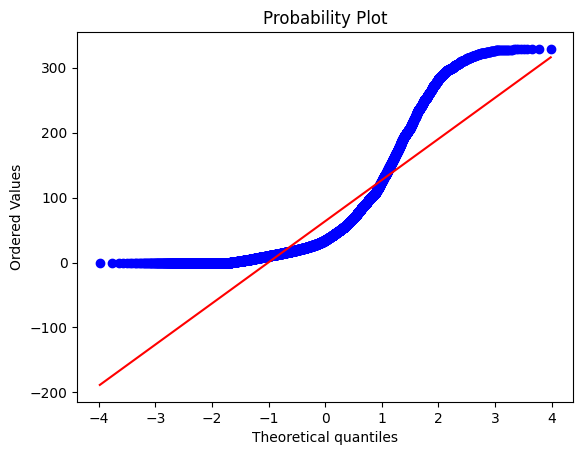

In [11]:
st.probplot(df_cleaned_iqr['total_buy'], plot=plt)

plt.show()

## Выводы

# Гипотезы

### Рассмотрим следующие гипотезы:
 1. Влияние заранее зарегистрировавшихся пользователей (задолго до первого логина/покупки) и пользователей, которые произвели покупку до регистрации
 2. Таргет может влиять на покупки или наоборот
 3. Влияние браузера на прибыльность или на скорость покупки.
 4. Рассмотреть превалирирование определённого браузера/браузеров у юзеров, совершивших больше всего возвратов. 
 5. Аномальные всплески покупок/возвратов за весь период анализа. Привязка к другим данным? Праздникам?

# Стратегия проверки: Строим графики, смотрим результаты, считаем. Думаем. Повторяем. (кто-нибудь помогите с формулировкой, пожалуйста)


### Гипотеза №1 "Консервы"
_Влияние заранее зарегистрировавшихся пользователей и пользователей, которые произвели покупку до регистрации_   

На выдвижение данной гипотезы меня натолкнула идея построения графиков зависимостей всех трёх дат (регистрация, первый логин, первая покупка) попарно, в поисках аномалий.

In [12]:
# обогащу таблицу разницей времени между тремя событиями
df_enriched = df_zcore_filtered.copy()

df_enriched["first_buy_reg_diff"] = (
    df_zcore_filtered["first_buy"] - df_zcore_filtered["reg_dt"]
).dt.days
df_enriched["first_login_buy_diff"] = (
    df_zcore_filtered["first_login"] - df_zcore_filtered["first_buy"]
).dt.days
df_enriched["first_login_reg_diff"] = (
    df_zcore_filtered["first_login"] - df_zcore_filtered["reg_dt"]
).dt.days
display(df_enriched.head(2))


,platform_num,first_login,reg_dt,browser,first_buy,target,total_buy,total_return,first_buy_reg_diff,first_login_buy_diff,first_login_reg_diff
user_id,,,,,,,,,,,
0,12,2025-03-22,2024-08-17,0,2025-03-22,0.0,85.329559,0.0,217,0,217
1,1,2025-05-05,2025-05-15,1,2025-05-20,0.0,21.819124,0.0,5,-15,-10


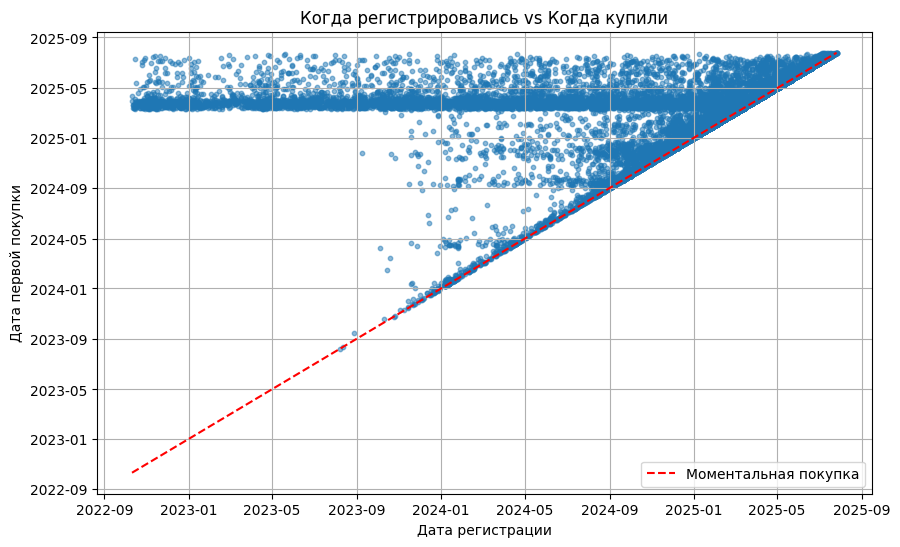

In [13]:
# Строим график зависимости дат регистрации и дат первой покупки
plt.figure(figsize=(10, 6))

# Рисуем точки
plt.scatter(df_enriched["reg_dt"], df_enriched["first_buy"], alpha=0.5, s=10)

# Добавляем линию "мгновенной покупки" (где X=Y), чтобы видеть задержку
# (для наглядности просто проведем диагональ)
min_date = df_enriched["reg_dt"].min()
max_date = df_enriched["first_buy"].max()
plt.plot(
    [min_date, max_date],
    [min_date, max_date],
    color="red",
    linestyle="--",
    label="Моментальная покупка",
)

plt.title("Когда регистрировались vs Когда купили")
plt.xlabel("Дата регистрации")
plt.ylabel("Дата первой покупки")
plt.legend()
plt.grid(True)
plt.show()


Видим аномальные отклонения от предсказуемой красной линии, есть объёмная группа юзеров, что регестрировались на протяжении всего периода, но покупки совершали в марте-апреле 2025. Это требует дополнительных исследований.

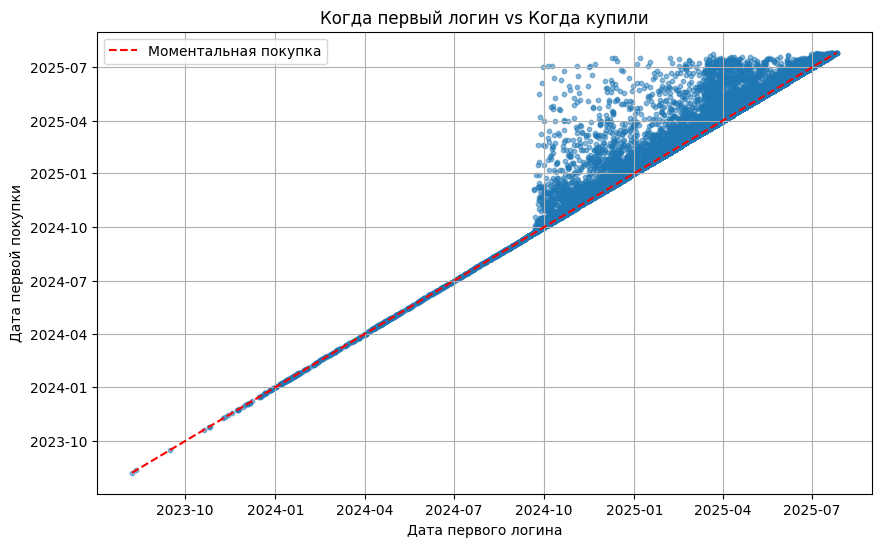

In [14]:
# Строим график зависимости дат первого логина и дат первой покупки
plt.figure(figsize=(10, 6))

# Рисуем точки
plt.scatter(df_enriched["first_login"], df_enriched["first_buy"], alpha=0.5, s=10)

# Добавляем линию "мгновенной покупки" (где X=Y), чтобы видеть задержку
# (для наглядности просто проведем диагональ)
min_date = df_enriched["first_login"].min()
max_date = df_enriched["first_buy"].max()
plt.plot(
    [min_date, max_date],
    [min_date, max_date],
    color="red",
    linestyle="--",
    label="Моментальная покупка",
)

plt.title("Когда первый логин vs Когда купили")
plt.xlabel("Дата первого логина")
plt.ylabel("Дата первой покупки")
plt.legend()
plt.grid(True)
plt.show()


Тут, предварительно, не выводится надёжной визуальной зависимости. Вертикальная разряженная линия появилась из-за заполнения значений first_buy от reg_dt, который не учавствует в данном графике.   
Это, дополнительно, проверяется отстройкой подобного графика на неочищенных данных:
# Возможно лишний график стоит убрать, он вызовет вопросы, а я отвечаю на то, о чём нас и не спрашивали.
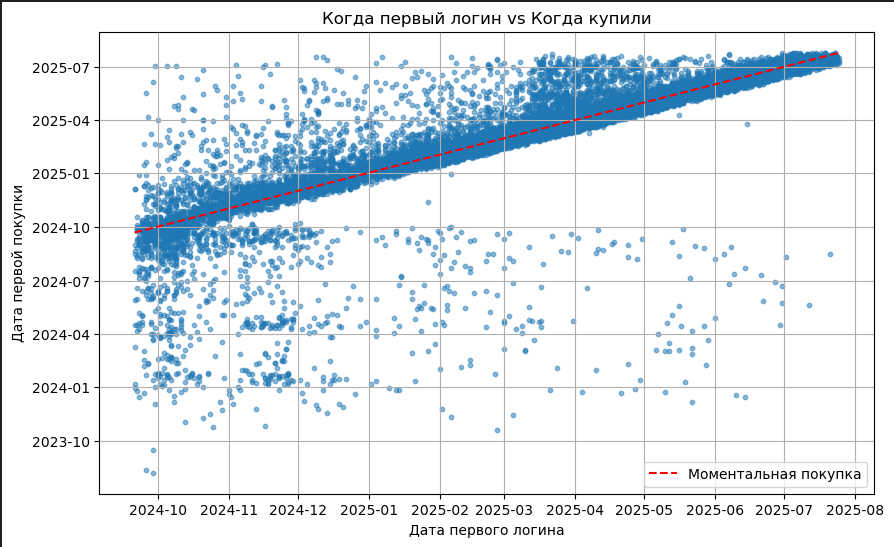

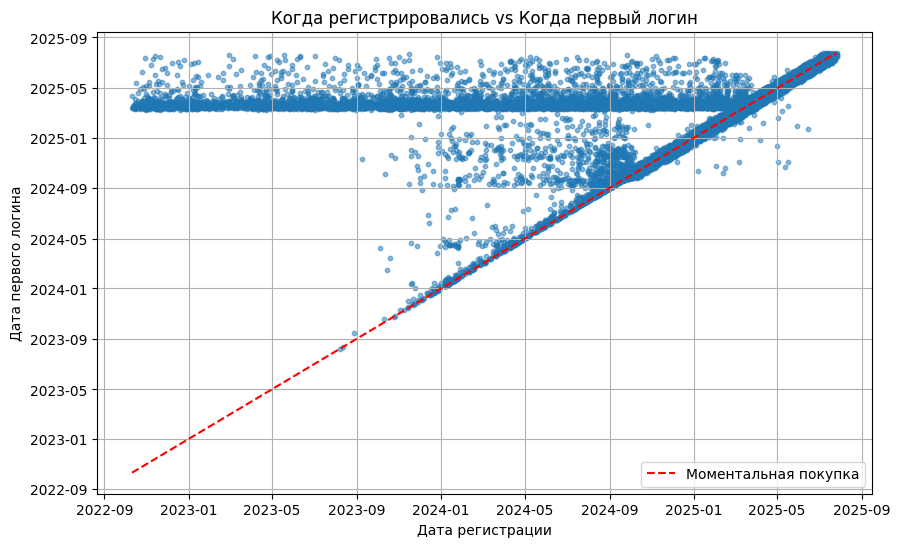

In [15]:
# Строим график зависимости дат регистрации и дат первого логина
plt.figure(figsize=(10, 6))

# Рисуем точки
plt.scatter(df_enriched["reg_dt"], df_enriched["first_login"], alpha=0.5, s=10)

# Добавляем линию "мгновенной покупки" (где X=Y), чтобы видеть задержку
# (для наглядности просто проведем диагональ)
min_date = df_enriched["reg_dt"].min()
max_date = df_enriched["first_login"].max()
plt.plot(
    [min_date, max_date],
    [min_date, max_date],
    color="red",
    linestyle="--",
    label="Моментальная покупка",
)

plt.title("Когда регистрировались vs Когда первый логин")
plt.xlabel("Дата регистрации")
plt.ylabel("Дата первого логина")
plt.legend()
plt.grid(True)
plt.show()


Видим аномалию, аналогичную первому графику, соответственно регистрация была давно, а первая покупка и логин (если это одни и те же пользователи) произведены в марте-апреле 2025.   
Также заметен дополнительный аномальный интервал к концу 2024 года, также требующий анализа. 

Для проведения анализа планируется выборка клиентов с "лагом" в датах более ~30-50 дней и сравнение их финансового вклада по сравнению с остальными пользователями.

### Гипотеза №4 "Браузерные войны!"
_Предпочтения браузера у юзеров, совершивших больше всего покупок/возвратов._   

Рассмотрим корреляцию используемых браузеров юзерами.

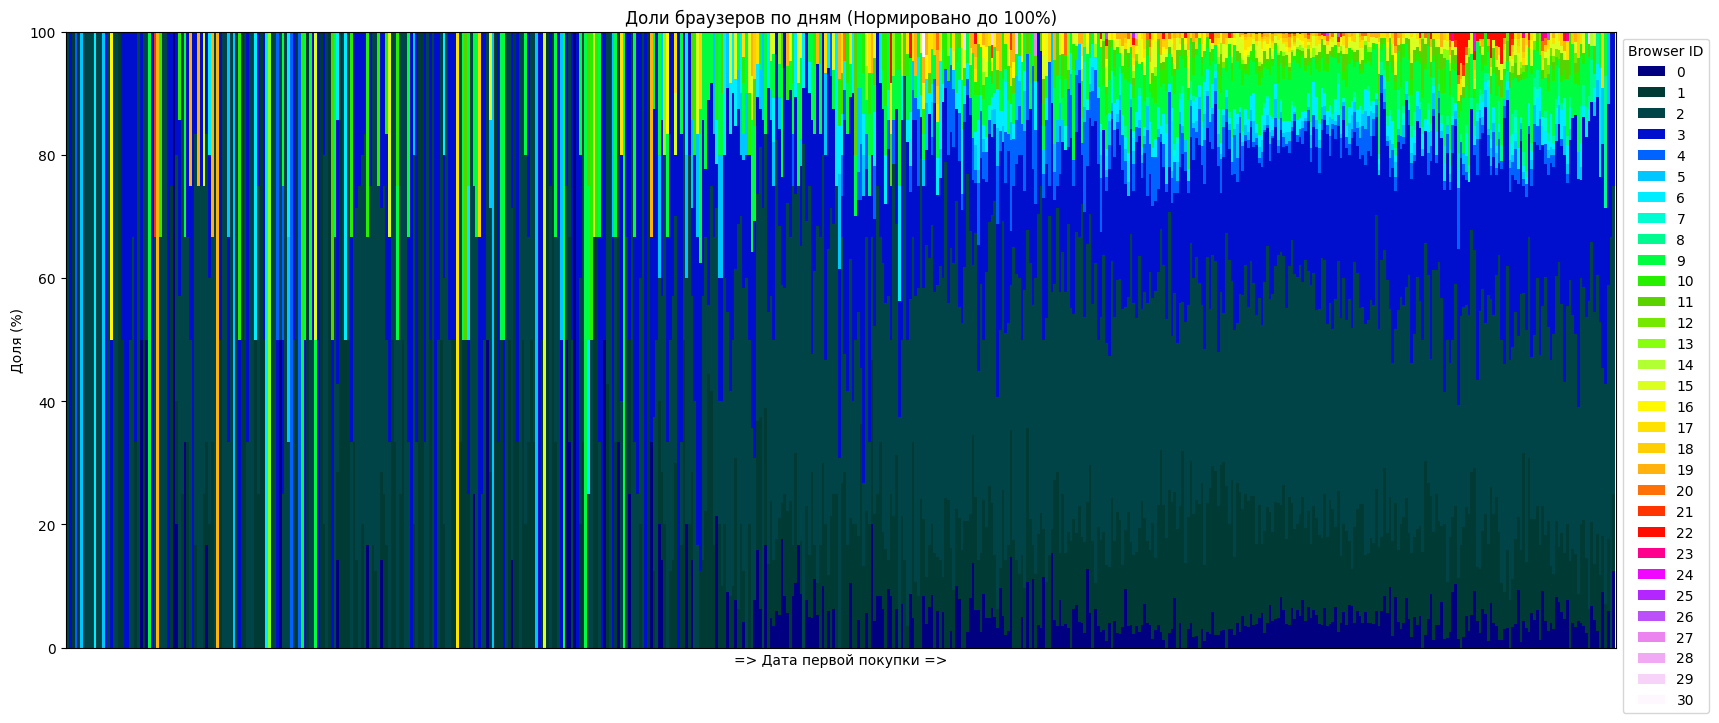

In [16]:
# Для этого построим нормализованный график предпочтений пользователей по браузерам, отсортировав по дате первой покупки.

raw_counts = (
    df_enriched.groupby([df_enriched["first_buy"].dt.date, "browser"])
    .size()
    .unstack(fill_value=0)
)

normalized_df = raw_counts.div(raw_counts.sum(axis=1), axis=0) * 100

ax = normalized_df.plot(
    kind="bar",
    stacked=True,
    title="Доли браузеров по дням (Нормировано до 100%)",
    figsize=(20, 8),
    cmap="gist_ncar",
    width=1,
)

plt.xticks([])
plt.xlabel("=> Дата первой покупки =>")
plt.ylabel("Доля (%)")
plt.ylim(0, 100)


plt.legend(title="Browser ID", bbox_to_anchor=(1, 1), loc="upper left")
plt.show()


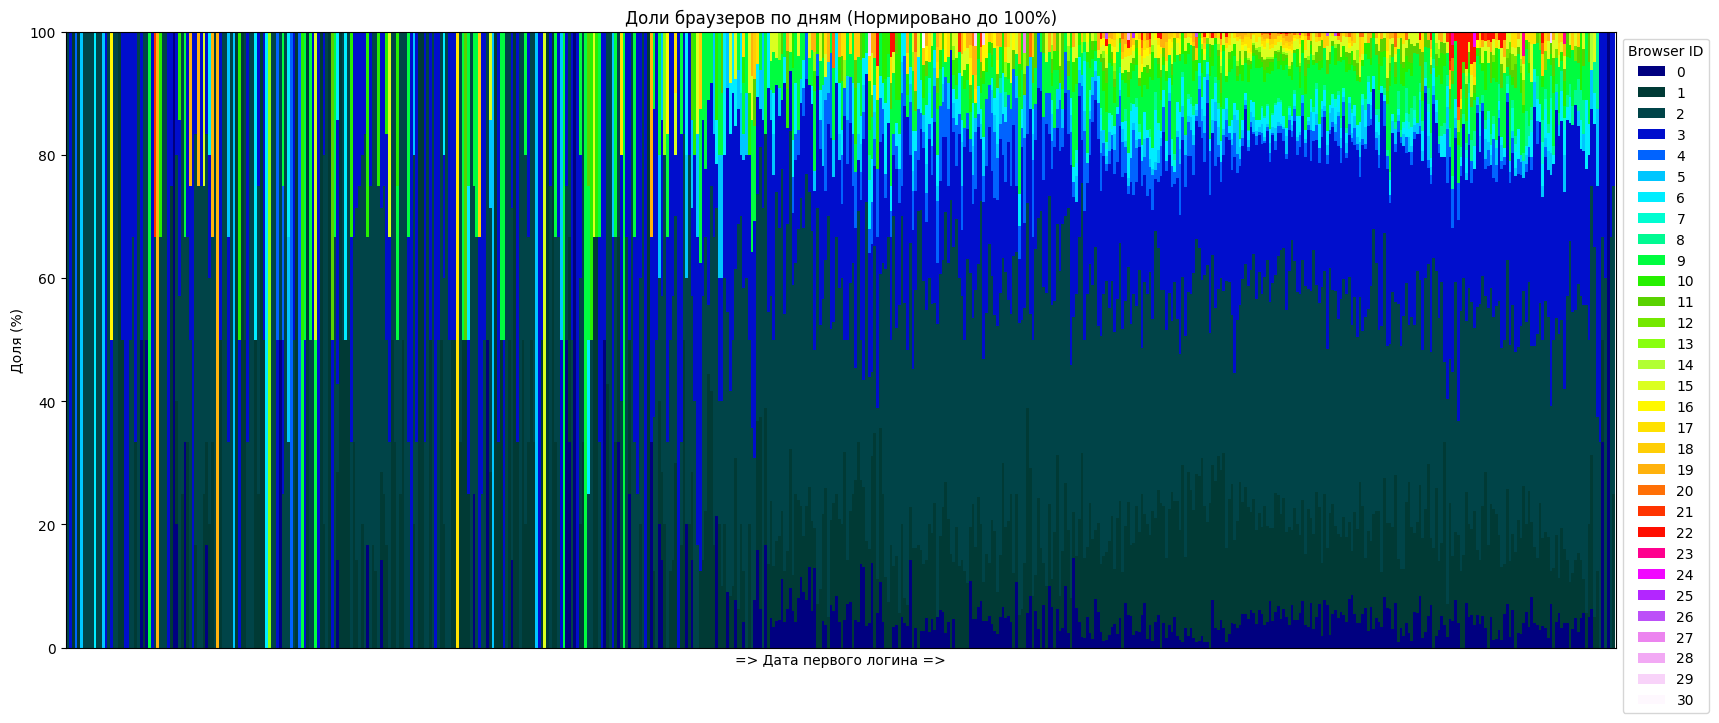

In [17]:
# Для этого построим нормализованный график предпочтений пользователей по браузерам, отсортировав по дате первого логина.

raw_counts = (
    df_enriched.groupby([df_enriched["first_login"].dt.date, "browser"])
    .size()
    .unstack(fill_value=0)
)

normalized_df = raw_counts.div(raw_counts.sum(axis=1), axis=0) * 100

ax = normalized_df.plot(
    kind="bar",
    stacked=True,
    title="Доли браузеров по дням (Нормировано до 100%)",
    figsize=(20, 8),
    cmap="gist_ncar",
    width=1,
)

plt.xticks([])
plt.xlabel("=> Дата первого логина =>")
plt.ylabel("Доля (%)")
plt.ylim(0, 100)


plt.legend(title="Browser ID", bbox_to_anchor=(1, 1), loc="upper left")
plt.show()


Видна разница в графиках, в зависимости от того, от какой даты отталкиваться. Нужно дополнительно построить отдельно для пользователей с возвратами.
# Александр, можно это смерджить с третьим пунктом, а можно оставить как две отдельные гипотезы. Т.к. твоя основана на базе данных и выглядит интересной. Плюс довольно легко изначально описывается.

### Гипотеза №5 "Дружно все покупаем!"
_Аномальные всплески покупок/возвратов за весь период анализа._  
 
На выдвижение данной гипотезы меня натолкнула идея построения графика покупок/возвратов относительно даты первого логина.    
Этот график не покажет реальные даты всех покупок, так как общая сумма каждого клиента будет приложена к дате его первого логина, но может показать клиентов, кто внёс большой вклад, с привязкой к данной дате.

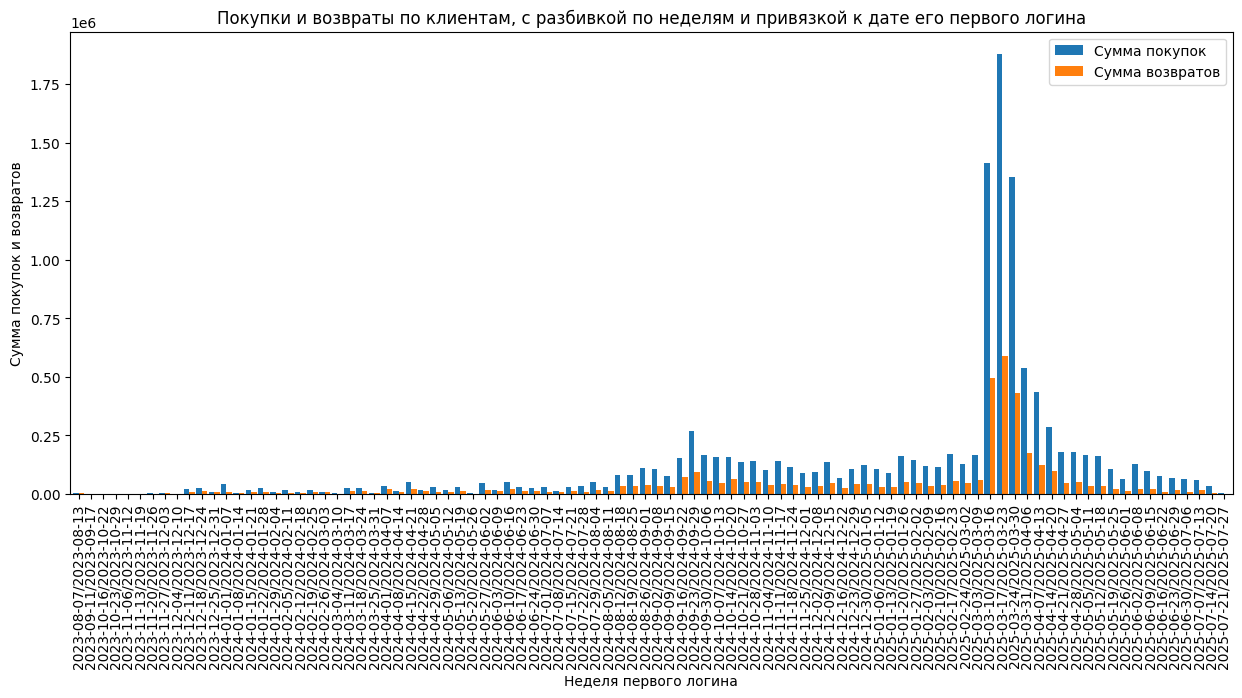

In [18]:
df_enriched["period"] = df_enriched["first_login"].dt.to_period("W")

(
    df_enriched.groupby("period")[["total_buy", "total_return"]]
    .sum()
    .plot(
        kind="bar",
        title="Покупки и возвраты по клиентам, с разбивкой по неделям и привязкой к дате его первого логина",
        figsize=(15, 6),
        width=0.9,
    )
)
plt.legend(["Сумма покупок", "Сумма возвратов"])
plt.xlabel("Неделя первого логина")
plt.ylabel("Сумма покупок и возвратов")
plt.show()


По данному графику видим две аномалии, в сентябре 2024 года и в март-апреле 2025. Вторая корреклирует с гипотезой №1.    
Для анализа потребуется искать причины аномальной активности данных пользователей и корреляцию с гипотезой №1 для второй кагорты.